https://api.bilibili.com/x/v1/dm/list.so?oid=201056987

In [ ]:
"""
以前爬取B站弹幕的时候，还是可以找到这个list_so接口的。但是现在就找不带到了
https://api.bilibili.com/x/v1/dm/list.so?oid=XXX
-------------------------------------------------------
我们为什么需要找到这个接口呢？
① 首先对于下面这个网址，我们可以拿到一个叫做cid的东西
https://api.bilibili.com/x/player/pagelist?bvid=BV1PK4y1b7dt&jsonp=jsonp
根据分析，这个cid=201056987
② 接着，将这个uid数据和最开始的链接进行拼接，就可以得到最终弹幕数据的网址
③ 最后，我们请求https://api.bilibili.com/x/v1/dm/list.so?oid=201056987这个网址，解析数据，得到我们最终想要的数据。
"""

In [ ]:
https://www.bilibili.com/video/BV1PK4y1b7dt?t=1
url = f'https://api.bilibili.com/x/player/pagelist?bvid={bvid}&jsonp=jsonp'

# 数据的爬取

In [42]:
import requests
import json
import chardet
import re
from pprint import pprint
# 1.根据bvid请求得到cid
def get_cid():
    url = 'https://api.bilibili.com/x/player/pagelist?bvid=BV1PK4y1b7dt&jsonp=jsonp'
    res = requests.get(url).text
    json_dict = json.loads(res)
    #pprint(json_dict)
    return json_dict["data"][0]["cid"]

# 2.根据cid请求弹幕，解析弹幕得到最终的数据
"""
注意：哔哩哔哩的网页现在已经换了，那个list.so接口已经找不到，但是我们现在记住这个接口就行了。
"""
def get_data(cid):
    final_url = "https://api.bilibili.com/x/v1/dm/list.so?oid=" + str(cid)
    final_res = requests.get(final_url)
    final_res.encoding = chardet.detect(final_res.content)['encoding']
    final_res = final_res.text
    pattern = re.compile('<d.*?>(.*?)</d>')
    data = pattern.findall(final_res)
    #pprint(final_res)
    return data

# 3.保存弹幕列表
def save_to_file(data):
    with open("dan_mu.txt", mode="w", encoding="utf-8") as f:
        for i in data:
            f.write(i)
            f.write("\n")

cid = get_cid()
data = get_data(cid)
save_to_file(data)

# 词云图的制作

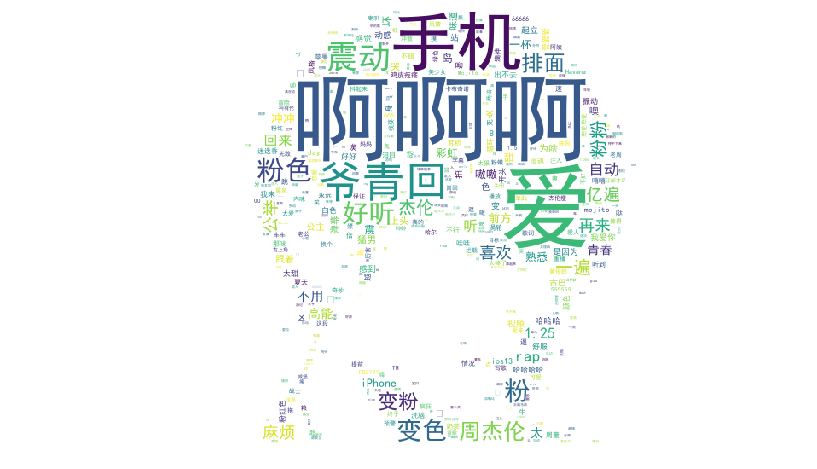

In [43]:
# ① 导入相关库
import pandas as pd
import jieba
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from imageio import imread

import warnings
warnings.filterwarnings("ignore")

# ② 读取文本文件，并使用lcut()方法进行分词
with open("dan_mu.txt",encoding="utf-8") as f:
    txt = f.read()
txt = txt.split()
data_cut = [jieba.lcut(x) for x in txt]
data_cut
# ③ 读取停用词
with open(r"G:\6Tipdm\wordcloud\data\stoplist.txt",encoding="utf-8") as f:
    stop = f.read()
stop = stop.split()
stop = [" ","道","说道","说"] + stop
# ④ 去掉停用词之后的最终词
s_data_cut = pd.Series(data_cut)
all_words_after = s_data_cut.apply(lambda x:[i for i in x if i not in stop])
# ⑤ 词频统计
all_words = []
for i in all_words_after:
    all_words.extend(i)
word_count = pd.Series(all_words).value_counts()
# ⑥ 词云图的绘制
# 1、读取背景图片
back_picture = imread(r"G:\6Tipdm\wordcloud\jay1.jpg")

# 2、设置词云参数
wc = WordCloud(font_path="G:\\6Tipdm\\wordcloud\\simhei.ttf",
               background_color="white",
               max_words=2000,
               mask=back_picture,
               max_font_size=200,
               random_state=42
              )
wc2 = wc.fit_words(word_count)

# 3、绘制词云图
plt.figure(figsize=(16,8))
plt.imshow(wc2)
plt.axis("off")
plt.show()
wc.to_file("ciyun.png")